# EuroBasket 2025 Team Analytics

This notebook explores team-level performance in EuroBasket 2025 using advanced metrics and modeling techniques. We begin by engineering a composite score to rank teams, then expand into clustering, predictive modeling, and style analysis.

Each section builds on the previous one to uncover deeper insights into team behavior, success factors, and strategic profiles.

In [ ]:
## Section 1: Composite Score Ranking

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('eurobasket_team_stats.csv',delimiter=';')

# Preview
df.head()

,#,Teams,GP,MPG,PTS,2PM-2PA,2P%,3PM-3PA,3P%,FTM-FTA,...,ORTG,DRTG,EFG%,DREB%,OREB%,FTRATE,AST%,PACE 40,PACE 48,STOCKS
0,19,Belgium,5,200,363,81-179,45.3,47-124,37.9,60-93,...,99.2,110.7,50.0,68.3,28.5,30.7,23.0,73.2,87.8,8.2
1,15,Bosnia and Herzegovina,6,200,473,116-208,55.8,57-178,32.0,70-115,...,110.3,112.4,52.2,68.6,35.0,29.8,28.0,71.5,85.8,9.8
2,24,Cyprus,5,200,295,74-168,44.0,39-139,28.1,30-39,...,85.0,130.3,43.2,62.2,22.5,12.7,19.6,69.4,83.3,6.2
3,23,Czechia,5,200,338,68-135,50.4,52-181,28.7,46-68,...,93.4,119.6,46.2,63.2,26.2,21.5,26.8,72.4,86.9,7.8
4,22,Estonia,5,200,352,78-169,46.2,46-147,31.3,58-79,...,98.9,111.8,46.5,70.1,28.4,25.0,27.2,71.2,85.4,6.8


In [5]:
# Strip column names
df.columns = df.columns.str.strip()

# Split composite columns
df[['2PM', '2PA']] = df['2PM-2PA'].str.split('-', expand=True).astype(float)
df[['3PM', '3PA']] = df['3PM-3PA'].str.split('-', expand=True).astype(float)
df[['FTM', 'FTA']] = df['FTM-FTA'].str.split('-', expand=True).astype(float)
df[['FGM_PG', 'FGA_PG']] = df['FGMPG-FGAPG'].str.split('-', expand=True).astype(float)
df[['3PM_PG', '3PA_PG']] = df['3PMPG-3PAPG'].str.split('-', expand=True).astype(float)
df[['FTM_PG', 'FTA_PG']] = df['FTMPG-FTAPG'].str.split('-', expand=True).astype(float)

# Drop originals
df.drop(columns=[
    '2PM-2PA', '3PM-3PA', 'FTM-FTA',
    'FGMPG-FGAPG', '3PMPG-3PAPG', 'FTMPG-FTAPG'
], inplace=True)

In [6]:
# Create point differential
df['PPG_diff'] = df['PPG'] - df['PAPG']

# Define weights
weights = {
    'NETRTG': 0.4,
    'EFFPG': 0.3,
    'PPG_diff': 0.2,
    'AST/TO': 0.1
}

# Calculate composite score
df['Score'] = (
    weights['NETRTG'] * df['NETRTG'] +
    weights['EFFPG'] * df['EFFPG'] +
    weights['PPG_diff'] * df['PPG_diff'] +
    weights['AST/TO'] * df['AST/TO']
)

In [7]:
# Sort and display top teams
df_ranked = df[['Teams', 'Score', 'NETRTG', 'EFFPG', 'PPG', 'PAPG', 'AST/TO']].sort_values(by='Score', ascending=False)
df_ranked.reset_index(drop=True, inplace=True)
df_ranked.head(10)

,Teams,Score,NETRTG,EFFPG,PPG,PAPG,AST/TO
0,Germany,54.42,31.7,122.4,99.9,75.9,2.2
1,Türkiye,44.93,21.6,109.9,90.2,74.5,1.8
2,Serbia,39.91,13.2,108.2,86.7,76.7,1.7
3,France,38.31,13.8,102.0,88.5,78.5,1.9
4,Greece,36.03,11.3,99.3,84.8,76.9,1.4
5,Lithuania,34.68,8.7,100.1,85.0,79.9,1.5
6,Italy,34.46,13.7,89.8,78.8,69.5,1.8
7,Slovenia,32.85,4.6,101.3,92.0,89.7,1.6
8,Spain,32.53,10.2,88.4,79.4,70.8,2.1
9,Finland,32.22,3.7,100.0,87.3,84.5,1.8


C:\Users\melis\AppData\Local\Temp\ipykernel_66776\1864899854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ranked.head(10), x='Score', y='Teams', palette='viridis')


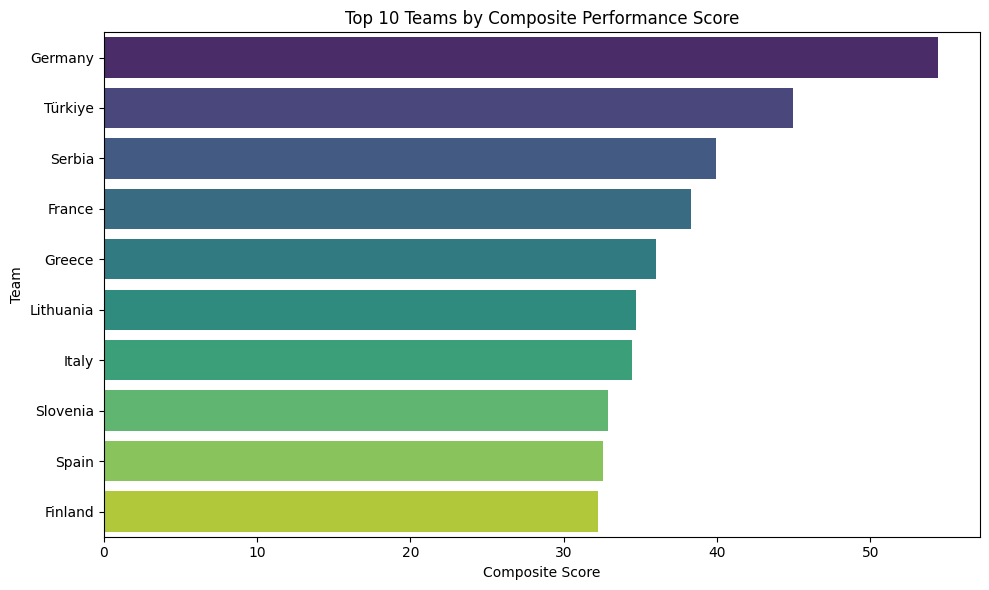

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ranked.head(10), x='Score', y='Teams', palette='viridis')
plt.title('Top 10 Teams by Composite Performance Score')
plt.xlabel('Composite Score')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

## 🧠 Summary of Findings

- Germany ranks highest due to elite NETRTG, EFFPG, and ball control.
- Türkiye and Serbia follow with strong scoring margins and efficiency.
- Teams with balanced offense, defense, and possession metrics rise to the top.
- AST/TO adds nuance, helping differentiate teams with similar scoring profiles.

In [ ]:
## Explanation of Composite Score Results

The composite score blends NETRTG, EFFPG, PPG - PAPG, and AST/TO to rank teams holistically. 
Germany’s dominance stems from high values across all metrics, while other teams rise or fall based 
on specific strengths or weaknesses. This score highlights well-rounded performance and sets the stage 
for clustering and predictive modeling.

## Section 2: Clustering Teams by Style (Coming Soon)

In the next section, we will group teams based on stylistic features such as pace, assist rate, shooting efficiency, and defensive activity. This will help identify strategic archetypes across EuroBasket 2025.

In [9]:
os.getcwd() 


'C:\\Users\\melis\\AppData\\Local\\Programs\\Python\\Python313\\Scripts'